In [58]:
import pickle
import numpy as np
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Display plot directly below the command that created it
%matplotlib inline

# READ DATA

The data is imported using the Keras library. According to the [documentation](https://keras.io/api/datasets/mnist/), the origin of this data is as follows:

Yann LeCun and Corinna Cortes hold the copyright for the MNIST dataset, which is a derivative work from the original NIST datasets.

This is the same origin as mentioned in the statements definition.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = set(y_test)

11490434/11490434 [==============================] - 0s 0us/step


# Exploratory data analysis (EDA)*texto en cursiva*

First, it will analyze whether the dataset is balanced to determine the appropriate validation metric for the results and to better understand the dataset being used.

In [4]:
def analise_dataset(y_dataset):
  # Print the results of the dataset analysis
  len_dataset = y_dataset.shape[0]
  print("* Number of samples:", len_dataset)
  print("* Labels' percentage:")

  for label in labels:
    num_samples_lable = sum(y_dataset == label)
    percentage_label = num_samples_lable * 100 / len_dataset
    print(f"\t* Label {label}: {num_samples_lable} sambles --> {percentage_label:.2f}% ")

In [5]:
print("TRAINING DATASET:")
analise_dataset(y_train)

print("TEST DATASET:")
analise_dataset(y_test)

TRAINING DATASET:
* Number of samples: 60000
* Labels' percentage:
	* Label 0: 5923 sambles --> 9.87% 
	* Label 1: 6742 sambles --> 11.24% 
	* Label 2: 5958 sambles --> 9.93% 
	* Label 3: 6131 sambles --> 10.22% 
	* Label 4: 5842 sambles --> 9.74% 
	* Label 5: 5421 sambles --> 9.04% 
	* Label 6: 5918 sambles --> 9.86% 
	* Label 7: 6265 sambles --> 10.44% 
	* Label 8: 5851 sambles --> 9.75% 
	* Label 9: 5949 sambles --> 9.91% 
TEST DATASET:
* Number of samples: 10000
* Labels' percentage:
	* Label 0: 980 sambles --> 9.80% 
	* Label 1: 1135 sambles --> 11.35% 
	* Label 2: 1032 sambles --> 10.32% 
	* Label 3: 1010 sambles --> 10.10% 
	* Label 4: 982 sambles --> 9.82% 
	* Label 5: 892 sambles --> 8.92% 
	* Label 6: 958 sambles --> 9.58% 
	* Label 7: 1028 sambles --> 10.28% 
	* Label 8: 974 sambles --> 9.74% 
	* Label 9: 1009 sambles --> 10.09% 


**Test-Train Rate**

85% of the dataset will be used for training, and the remaining 15% for testing. This rate is established in the dataset itself.

**Labels Analysis**

There are 10 labels in the dataset, and both the training and testing data are balanced, with around 1,000 samples per label in the test set and 6,000 in the training set.


Now, it will analyze the samples' format, focusing on the samples' shapes and the range of values.

In [69]:
print("Mean data:", x_train[:10].mean())
print("Max data:", x_train[:10].max())
print("Min data:", x_train[:10].min())
print("Sample shape:", x_train.shape[1:])

Mean data: tensor(0.1102)
Max data: tensor(1.)
Min data: tensor(0.)
Sample shape: torch.Size([1, 28, 28])


In [7]:
def plot_sample(image):
  # Plot the input sample

  fig = plt.figure
  plt.imshow(image, cmap='gray')
  plt.show()

Plot a train sample representing the label 0, in order to understand the data that we will be working with.

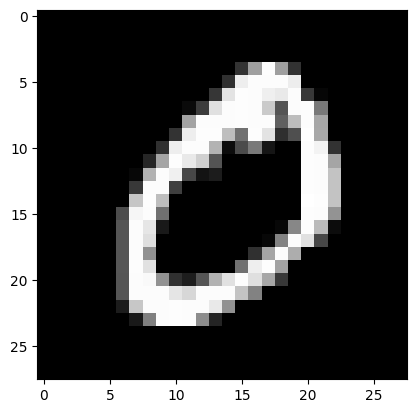

In [7]:
plot_sample(x_train[y_train==0][0])

**Samples Analysis**

Each sample comprises a 28x28 grayscale image, with pixel values ranging from 0 to 255. Upon inspecting the plotted image and analyzing the data statistics, it becomes evident that there's a predominant occurrence of values around 0 and 255, with a notable concentration at 0, as indicated by the mean. (This analysis is supported by the histogram plotted in the processing section of the notebook.)

Based on these results, it appears promising to use binarization in order to:
* Reduce computational cost
* Simplify the model
* Reduce noise
* Improve generalization
* Speed up the training process



# Data preprocessing and feature engineering (if required)


The preprocessing section will involve binarizing the sample data, as outlined in the data analysis section. Initially, it calculates the optimal threshold based on the least frequent color value from 50 random samples. This approach is chosen because computing the histogram of all training samples is excessively costly, and 50 samples provide sufficient data to calculate an average. Additionally, a histogram is plotted to visually confirm that the values are predominantly clustered at the extremes, verifying the optimal threshold is applied.

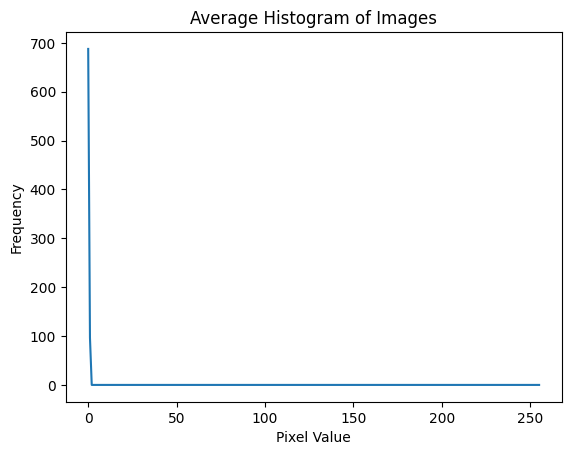

Optimal threshold value for binarization 2


In [68]:
HISTOGRAM_SAMPLES_SELECTED = 50

def plot_histogram(average_histogram):
  # Plot the average histogram

  plt.plot(average_histogram)
  plt.title('Average Histogram of Images')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')
  plt.show()


def get_optimal_binarization_threshold(x_dataset):
  # Returns the optimal threshold value for the preprocessing binarization

  # Select a random sample of HISTOGRAM_SAMPLES_SELECTED pictures
  selected_indices = np.random.choice(len(x_dataset),
                                      HISTOGRAM_SAMPLES_SELECTED,
                                      replace=False)

  selected_images = x_dataset[selected_indices]

  # Calculate histograms for each image
  histograms = [np.histogram(image.flatten(), bins=256, range=(0, 255))[0]
                for image in selected_images]

  # Average the histograms
  average_histogram = np.mean(histograms, axis=0)
  plot_histogram(average_histogram)

  optimal_threshold = average_histogram.argmin()
  print("Optimal threshold value for binarization", optimal_threshold)

  return optimal_threshold

# Assuming x_train is your array of images
binarization_threshold = get_optimal_binarization_threshold(x_train)

In [14]:
# Define thresholding function
def binarize_images(images, threshold):
    binary_images = np.where(images > threshold, 1, 0)
    return binary_images

# Binarize train and test images
x_train_binary = binarize_images(x_train, binarization_threshold)
x_test_binary = binarize_images(x_test, binarization_threshold)

Transform the samples into 1D arrays for compatibility with the x_train data, preparing them for input into the models.

In [70]:
x_train_binary_flat = x_train_binary.reshape((x_train_binary.shape[0], -1))
x_test_binary_flat = x_test_binary.reshape((x_test_binary.shape[0], -1))

print("Train data before resizing it:", x_train_binary.shape)
print("Train data after resizing it:", x_train_binary_flat.shape)
print("Test data before resizing it:", x_test_binary.shape)
print("Test data after resizing it:", x_test_binary_flat.shape)

Train data before resizing it: (60000, 28, 28)
Train data after resizing it: (60000, 784)
Test data before resizing it: (10000, 28, 28)
Test data after resizing it: (10000, 784)


# Model seleccion and configuration

To identify the best models, three papers that used the same dataset were looked into:

- In one study by [Paper 1](https://www.joig.net/uploadfile/2018/0717/20180717055805469.pdf), the highest accuracy (80.25%) was achieved using a neural network (NN) and K-nearest neighbors (KNN) with an accuracy of 75.96%.

- Another research [Paper 2](https://iopscience.iop.org/article/10.1088/1757-899X/1022/1/012108/pdf) found that the support vector machine (SVM) gave the highest accuracy of 95.88% with the least computational time.

- Also, [Paper 3](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9823806) reported impressive results with a convolutional neural network (CNN), hitting an accuracy of 98.68% with a simple CNN architecture and 99.23% with a Deep CNN.

Based on these findings, the CNN, KNN, and SVM models were chosen. These models were the top picks in the state-of-the-art, and by testing them, we can explore a range of approaches.

In [63]:
def train_model_using_grid_search(clf, param_grid, x_train, y_train):
  # Train input model using gri search to analyse the best parameters. It returns
  # the most promising classifier
  grid_search = GridSearchCV(estimator=clf,
                             param_grid=param_grid,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1,
                             verbose=3)

  # Fit the model with grid search
  grid_search.fit(x_train, y_train)


  # Get the best parameters and best score
  print(f"Best parameters: { grid_search.best_params_}")
  print(f"Best cross-validation score: {grid_search.best_score_}")

  # Get the best estimator (the model with the best found parameters)
  best_knn = grid_search.best_estimator_

  return best_knn

In [18]:
def save_model(filename, clf):
  # Save model in pickle file
  pickle.dump(clf, open(filename, 'wb'))


def load_model(filename):
  # Load model from pickle file
  return pickle.load(open(filename, 'rb'))

## KNN

A parameter tune was carried out to find the best configurations for the model. Here are the results: Best parameters: {'n_neighbors': 9, 'weights': 'distance'}

In [20]:
KNN_MODEL_FILENAME = "knn_model.sav"

In [ ]:
def knn_grid_search():
  # Apply grdSearch to find the most optimal parameters in the KNN model
  knn_param_grid = {
      'n_neighbors': [9, 11, 15],
      'weights': ['uniform', 'distance']
  }

  knn_clf = KNeighborsClassifier()

  best_knn_clf = train_model_using_grid_search(knn_clf,
                                              knn_param_grid,
                                              x_train_binary_flat,
                                              y_train)
  save_model(KNN_MODEL_FILENAME, best_knn_clf)
  return save_model

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation score: 0.9591000000000001


In [21]:
knn_clf = KNeighborsClassifier(n_neighbors=9, weights='distance')
knn_clf.fit(x_train_binary_flat, y_train)
save_model(KNN_MODEL_FILENAME, knn_clf)

In [34]:
knn_clf = load_model(KNN_MODEL_FILENAME)

## SVM

In [44]:
SVM_MODEL_FILENAME = "svm_model.sav"

In [61]:
def svm_grid_search():
  svm_param_grid = {
      'C': [0.1, 1, 10],
      'gamma': [0.001, 0.01, 1],
      'kernel': ['linear', 'rbf']
  }

  svm_clf = svm.SVC()

  best_svm_clf = train_model_using_grid_search(svm_clf,
                                              svm_param_grid,
                                              x_train_binary_flat,
                                              y_train)
  save_model(SVM_MODEL_FILENAME, best_svm_clf)

In [ ]:
svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(x_train_binary_flat, y_train)
save_model(SVM_MODEL_FILENAME, svm_clf)

In [35]:
svm_clf = load_model(SVM_MODEL_FILENAME)

## CNN

The convolutional neural network (CNN) model was constructed using PyTorch. In the research paper authored by Elizabeth Rani et al. titled 'MNIST Handwritten Digit Recognition using Machine Learning,' they detail the architecture employed in their CNN model with the identical dataset, attaining an accuracy of 98.68%.

The same architecture has been replicated to ensure the optimal performance of the model.

In [46]:
NUM_EPOCHS = 10
CNN_MODEL_FILENAME = "cnn_model.pickle"

In [48]:
class CNN(nn.Module):
  """
  Define the CNN model based in the arquitecture from the paper MNIST Handwritten
  Digit Recognition using Machine Learning by G, Elizabeth Rani et al.
  """
  def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)   # (28, 28, 32)
      self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                  # (14, 14, 32)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # (14, 14, 64)
      self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                  # (7, 7, 64)
      self.flatten = nn.Flatten()                                         # (3136)
      self.fc1 = nn.Linear(7 * 7 * 64, 1024)                              # (1024)
      self.dropout = nn.Dropout(0.5)
      self.fc2 = nn.Linear(1024, 10)                                      # (10)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool1(x)
      x = F.relu(self.conv2(x))
      x = self.pool2(x)
      x = self.flatten(x)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      return x

In [51]:
# Convert NumPy arrays to PyTorch tensors and add the channel dimension
x_train = torch.tensor(x_train_binary, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test_binary, dtype=torch.float32).unsqueeze(1)    # Add channel dimension
y_test = torch.tensor(y_test, dtype=torch.long)

# Split the data into train and validation sets
x_train_reduced, x_val, y_train_reduced, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Create DataLoader for batching
train_dataset = TensorDataset(x_train_reduced, y_train_reduced)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [48]:
def train_one_epoch(model, epoch_index):
  """
  Train one epoch of the model introduced
  """
  running_loss = 0.0

  for idx, data in enumerate(train_loader):

      inputs, inputs_labels = data

      cnn_optimizer.zero_grad()
      outputs = model(inputs)
      loss = cnn_criterion(outputs, inputs_labels)
      loss.backward()

      # Adjust learning weights
      cnn_optimizer.step()

      # Gather data and report
      running_loss += loss.item()

  avg_tloss = running_loss / len(train_loader)

  return model, avg_tloss


def train_cnn_model(model, criterion, optimizer):
  """
  Train the CNN model and return the loss history of the train and val dataset
  """
  train_losses_hist, val_losses_hist = [], []

  # Training loop
  for epoch in range(NUM_EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Training
    model.train(True)
    model, avg_tloss = train_one_epoch(model, epoch)

    # Evaluation
    model.eval()
    running_vloss = 0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():

      for idx, vdata in enumerate(val_loader):

        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = cnn_criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / len(test_loader)
    print('LOSS train {} val {}'.format(avg_vloss, avg_vloss))

    train_losses_hist += [avg_tloss]
    val_losses_hist += [avg_vloss]

  return model, train_losses_hist, val_losses_hist

In [49]:
# Initialize the model, loss function, and optimizer

cnn_clf = CNN()
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_clf.parameters(), lr=0.001)

cnn_clf, train_losses_hist, val_loss_history = train_cnn_model(cnn_clf, cnn_criterion, cnn_optimizer)

# Save CNN model
with open(CNN_MODEL_FILENAME, "wb") as fp:
    pickle.dump(cnn_clf.state_dict(), fp)

EPOCH 1:
LOSS train 0.0688747689127922 val 0.0688747689127922
EPOCH 2:
LOSS train 0.05807070434093475 val 0.05807070434093475
EPOCH 3:
LOSS train 0.06181461364030838 val 0.06181461364030838
EPOCH 4:
LOSS train 0.04867897927761078 val 0.04867897927761078
EPOCH 5:
LOSS train 0.05922597646713257 val 0.05922597646713257
EPOCH 6:
LOSS train 0.05493656545877457 val 0.05493656545877457
EPOCH 7:
LOSS train 0.056409332901239395 val 0.056409332901239395
EPOCH 8:
LOSS train 0.06476849317550659 val 0.06476849317550659
EPOCH 9:
LOSS train 0.06951986253261566 val 0.06951986253261566
EPOCH 10:
LOSS train 0.06067802757024765 val 0.06067802757024765


To evaluate whether the model effectively learns to generalize with the training data, the loss function has been plotted. This allows for comparison between the loss functions of the training and validation datasets.

In summary, while the plot suggests some overfitting, the model still demonstrates good generalization, as indicated by its high test accuracy. It's possible that the architecture is too complex for the available data. Since the data preprocessing differs from that reported in the paper, it would be prudent to consider simplifying the model and adjusting the parameters to evaluate whether the validation loss function also decreases

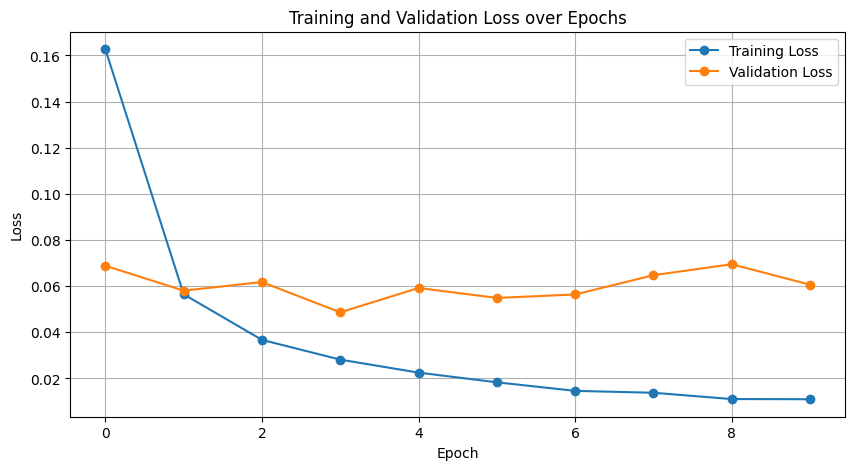

In [55]:
def plot_loss_function(train_losses_hist, val_loss_history):
  """
  Given the loss training and validation datasets history, this function will
  plot their loss function.
  """
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses_hist, marker='o', label='Training Loss')
  plt.plot(val_loss_history, marker='o', label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()


plot_loss_function(train_losses_hist, val_loss_history)

In [49]:
 def load_pytorch_model(filename):
  model = CNN()
  with open(filename, "rb") as fp:
    model.load_state_dict(pickle.load(fp))

  return model

cnn_clf = load_pytorch_model(CNN_MODEL_FILENAME)

# MODEL'S VALIDATION

The metric used for validating the models has been accuracy. This choice is justified by several factors:

- The dataset is balanced.
- It's assumed that misclassification of any class is equally detrimental.
- The optimal threshold has been used.

To assess the performance of each model, both accuracy and confusion matrices are ploted.

While accuracy may vary with each execution, in the last run, the following results were obtained:
- KNN: 97.45%
- SVM: 97.45%
- CNN: 98.85%

The confusion matrix confirms the satisfactory performance of each model. Some test samples are misclassified, with the affected labels varying depending on the model. However, overall, the performance is quite robust.


In [41]:
def display_accuracy(y_pred, y_true):
    acc = (y_pred == y_true).sum() * 100 / len(y_true)
    print(f"Model's accuracy: {acc:.2f}%")

In [80]:
def plot_conf_matrix(true_labels, predictions):
  conf_matrix = confusion_matrix(true_labels, predictions)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

## KNN

Model's accuracy: 95.37%


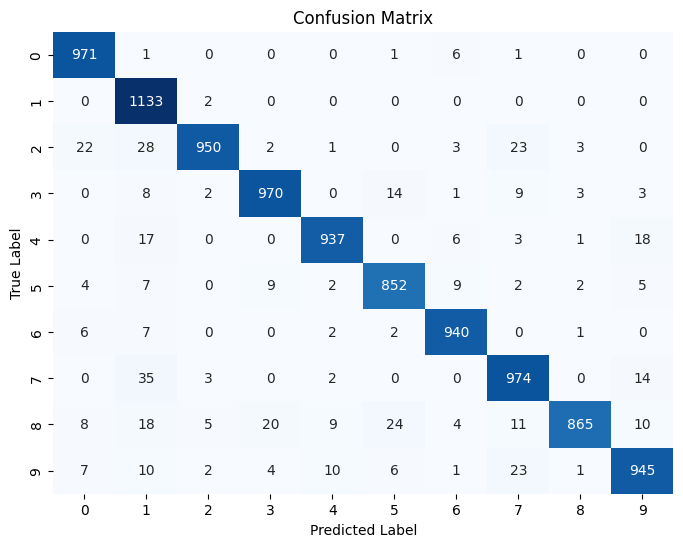

In [81]:
knn_pred = knn_clf.predict(x_test_binary_flat)
display_accuracy(knn_pred, y_test.numpy())
plot_conf_matrix(y_test, knn_pred)

## SVM

Model's accuracy: 97.45%


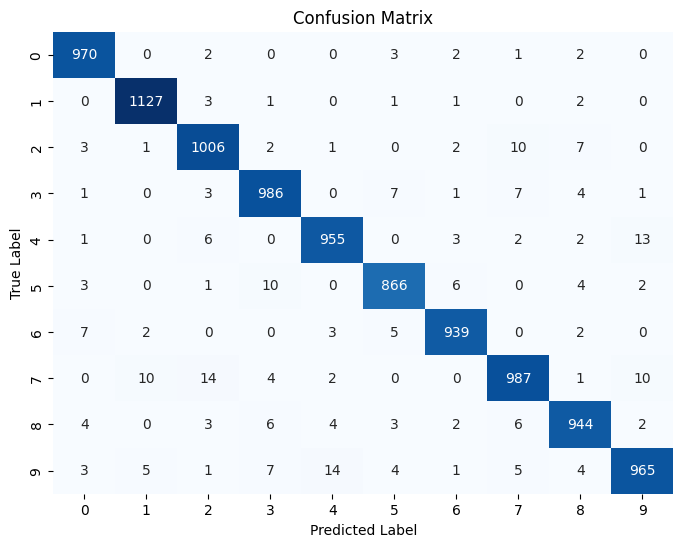

In [43]:
svm_pred = svm_clf.predict(x_test_binary_flat)
display_accuracy(svm_pred, y_test.numpy())
plot_conf_matrix(y_test, svm_pred)

## CNN

In [55]:
def evaluate_model(model, test_loader):
  model.eval()
  predictions = []

  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          predictions.extend(predicted.tolist())

  return np.array(predictions)

In [56]:
cnn_pred = evaluate_model(cnn_clf, test_loader)

CNN accuracy: 98.85%



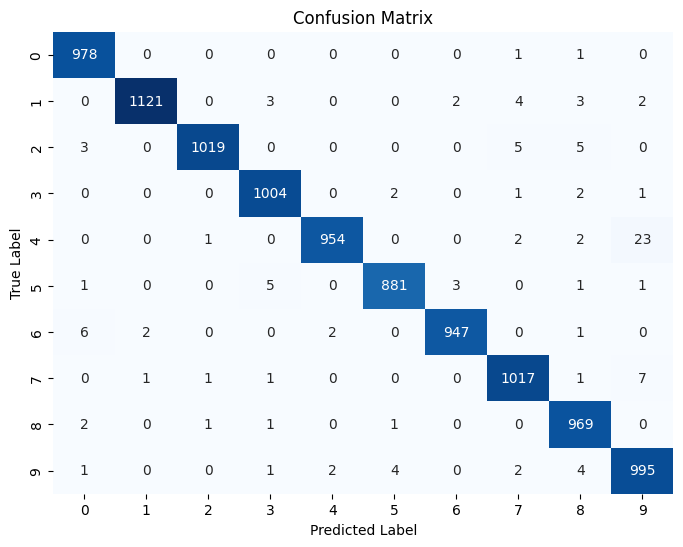

In [72]:
display_accuracy(cnn_pred, y_test)
plot_conf_matrix(y_test, cnn_pred)